# Assigning NBA Archetypes Through K-Means Clustering

**Objective:**  
To classify NBA players into distinct player archetypes using K-Means clustering, based on advanced metrics and shooting profiles. The model uncovers underlying player types by analyzing statistical tendencies rather than relying on traditional position labels.

**Use Case:** 
Basketball demands a diverse mix of complementary skillsets across a roster. This model equips NBA front offices with a data-driven framework to evaluate the composition of their team and identify gaps or redundancies.
By mapping each player to a statistical archetype, teams can:
- Assess how many players occupy a given role, flagging potential overlap or redundancy.
- Identify missing archetypes that may be critical to roster balance, such as floor-spacing bigs, low-usage defenders, or secondary creators.
- Scout external talent by matching desired archetypes to available players across the league.
Ultimately, this clustering model serves as a strategic tool for roster construction, player development, and trade evaluation — helping teams build more cohesive, complementary lineups grounded in objective player profiles

---

### Model Overview

- **Target Variables:**  
  Arhcetype: Aggregated advanced metrics, shooting splits, and per-36-minute production, weighted by games played to reflect meaningful contributions.
  
- **Feature Set:**  
  The model integrates config-driven subsets of advanced stats (e.g., true shooting, usage rate), spatial shooting tendencies (e.g., percent of FGA from zones), and scoring volume. These features are selected to capture player efficiency, shot distribution, and scoring role.

- **Preprocessing Strategy:**  
  A custom preprocessor fills structural zeros (e.g., non-attempted shots) with domain-informed defaults, imputes missing shooting and assisted percentages using season-aware or global averages, and standardizes numeric features. Metadata such as player ID, season, and position are preserved for post-hoc analysis.

- **Clustering Objective:**  
  K-Means is used to group players into archetypes based on their statistical profiles. Position labels are retained for interpretability but excluded from feature inputs, allowing clusters to emerge purely from data-driven patterns.

  
- **Model Framing:**  
  The pipeline is designed for reproducibility and extensibility, enabling scalable analysis of player types across seasons. It supports post-hoc inspection of cluster composition, representative players, and feature distributions to inform scouting, development, and roster construction.

---

### Limitations & Future Enhancements

- **Missing Data Bias:**  
  Players with sparse shooting data or limited minutes may be imputed with season averages, potentially masking unique traits or underrepresenting niche archetypes.

- **Fixed Cluster Count:**  
  The number of clusters is manually set, which may not reflect the true number of emergent player types. Dynamic selection methods (e.g., silhouette score, gap statistic) could improve robustness.

- **No Temporal Modelling:**  
  The model clusters players per season but does not track how archetypes evolve over time. Future versions could incorporate longitudinal analysis to capture career trajectories.

- **Contextual Blindspots:**  
  Role changes, coaching systems, injuries, and team context are not modeled, yet they heavily influence player output. These factors are candidates for future inclusion.

- **Interpretability Tools:**  
  While position composition is summarized, deeper cluster inspection tools (e.g., centroid profiles, top differentiating features) would enhance interpretability and support manual labeling.

- **Era Sensitivity:**  
  The model currently operates within a fixed multi-year window. Expanding to cross-era comparisons would require pace-adjusted and league-relative metrics to ensure fairness.


## Library Installation and Data Ingestion

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

advanced_stats = pd.read_csv('Advanced.csv')
shooting_stats = pd.read_csv('Player Shooting.csv')
per_36_stats = pd.read_csv('Per 36 Minutes.csv')

## Error Handling Function

In [2]:
def weighted_mean_ignore_nan(values, weights):
    values = pd.to_numeric(values, errors="coerce")
    weights = pd.to_numeric(weights, errors="coerce")
    mask = ~values.isna() & ~weights.isna()
    if mask.sum() == 0:
        return np.nan
    return np.average(values[mask], weights=weights[mask])

## Preprocessing: Feature Engineering

### `aggregate_player_stats`
Performs a weighted aggregation of player statistics within a single season. The source CSV files store unique rows for each combination of `player`, `player_id`, `team`, and `season`. As a result, players who appeared on multiple teams in the same season do not require duplicate rows — their stats are consolidated into a single seasonal record.


In [3]:
def aggregate_player_stats(df, seasons, drop_cols=None, weight_col="g"):
    required = {"player", "player_id", "season"}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        raise ValueError(f"Missing required columns: {missing}")
        
    if isinstance(seasons, (list, tuple, set)):
        df_season = df[df["season"].isin(seasons)].copy()
    else:
        df_season = df[df["season"] == seasons].copy()

    if drop_cols:
        drop_cols = [c for c in drop_cols if c not in ["season", "pos"]]
        df_season = df_season.drop(columns=drop_cols, errors="ignore")

    grouped = df_season.groupby(["player", "player_id", "season"], sort=False)

    rows = []
    for (player, pid, season), g in grouped:
        row = {"player": player, "player_id": pid, "season": season}
        if "pos" in g.columns:
            row["pos"] = g["pos"].mode().iloc[0]
        for col in g.columns:
            if col not in [weight_col, "player", "player_id", "pos", "season"]:
                row[col] = weighted_mean_ignore_nan(g[col], g[weight_col])
        rows.append(row)

    return pd.DataFrame(rows)

### Configs Overview
This project is designed to be modular, with preprocessing functions reused across multiple CSV files. To ensure consistency, configuration settings for data preparation must be defined. Since some CSVs contain irrelevant or duplicate columns, these redundant features are identified and removed during preprocessing

In [4]:
configs = {
    "adv": {
        "df": advanced_stats[~advanced_stats["ts_percent"].isna()].copy(),
        "drop_cols": ["lg", "team", "gs"],
        "suffix": "_adv"
    },
    "shoot": {
        "df": shooting_stats,
        "drop_cols": [
            "lg", "team", "age", "gs", "mp", "fg_percent",
            "num_heaves_attempted", "num_heaves_made"
        ],
        "suffix": "_shoot"
    },
    "per36": {
        "df": per_36_stats,
        "drop_cols": [c for c in per_36_stats.columns
                      if c not in ["player", "player_id", "pts_per_36_min", "g", "season"]],
        "suffix": "_per36"
    }
}

### `build_merged_stats`
Combines the meaningful features from the datasource CSV files into one single dataframe which can then be used for model training. 

In [5]:
def build_merged_stats(configs, seasons):
    aggregated = {
        key: aggregate_player_stats(cfg["df"], seasons, cfg["drop_cols"])
        for key, cfg in configs.items()
    }

    merged = aggregated["adv"]
    for key, cfg in configs.items():
        if key == "adv":
            continue
        merged = merged.merge(
            aggregated[key],
            on=["player", "player_id", "season"],
            how="inner",
            suffixes=("", cfg["suffix"])
        )
    return merged

### `NBAClusterPreprocessor`

Handles preprocessing of raw NBA stats before clustering:
- Identifies relevant numeric features (shooting splits, assist rates, etc.)
- Fills missing values with season or global averages
- Standardises numeric features using `StandardScaler`
- Preserves metadata (player, season, position) for later interpretation

**Inputs:**  
- Raw merged stats dataframe

**Outputs:**  
- `features`: standardised numeric feature matrix  
- `meta`: metadata (IDs, player names, positions, seasons)


In [6]:
class NBAClusterPreprocessor:
    def __init__(self):
        self.scaler = None
        self.season_means = {}
        self.global_means = {}
        self.fg_cols = []
        self.assist_cols = []
        self.attempt_cols = []
        self.id_cols = ["player", "player_id", "season", "pos"]

    def fit(self, df):
        self.attempt_cols = [c for c in df.columns 
                             if "percent_fga_from" in c 
                             or c in ["percent_dunks_of_fga", "percent_corner_3s_of_3pa"]]
        self.fg_cols = [c for c in df.columns 
                        if "fg_percent_from" in c or c in ["corner_3_point_percent"]]
        self.assist_cols = [c for c in df.columns if "percent_assisted" in c]

        for c in self.fg_cols + self.assist_cols:
            self.season_means[c] = df.groupby("season")[c].mean()
            self.global_means[c] = df[c].mean()

        num_cols = df.select_dtypes(include=[np.number]).columns
        self.scaler = StandardScaler().fit(df[num_cols])
        return self

    def transform(self, df):
        df = df.copy()
        keep_cols = [c for c in self.id_cols if c in df.columns]
        meta = df[keep_cols].copy()

        if self.attempt_cols:
            df[self.attempt_cols] = df[self.attempt_cols].fillna(0)

        for c in self.fg_cols + self.assist_cols:
            if c in df.columns:
                df[c] = df.apply(
                    lambda row: row[c] if pd.notna(row[c])
                    else self.season_means[c].get(row["season"], self.global_means[c]),
                    axis=1
                )

        num_cols = df.select_dtypes(include=[np.number]).columns
        df[num_cols] = self.scaler.transform(df[num_cols])
        features = df[num_cols]
        return features, meta

### Clustering Pipeline Overview

These functions perform unsupervised clustering on NBA player data using K-Means, offering  optimisation, interpretation, and visualisation.

---

### `run_clustering_pipeline()`
Executes the full clustering workflow:
- Merges player statistics across selected seasons using `build_merged_stats()`
- Applies preprocessing via `NBAClusterPreprocessor`:
  - Standardizes features
  - Extracts metadata for later interpretation
- Imputes missing values using the specified strategy (default: `"mean"`)
- Optionally applies PCA for dimensionality reduction
- Fits a **K-Means** model with the specified number of clusters
- Appends cluster labels to player metadata

---

#### **Inputs**
- `configs`: dictionary of dataset configurations  
- `seasons`: list of seasons to include  
- `n_clusters`: number of clusters to form (default: 10)  
- `use_pca`: whether to apply PCA before clustering (default: True)  
- `n_pca_components`: number of PCA components to retain (default: 10)  
- `impute_strategy`: strategy for handling missing values (default: `"mean"`)  
- `random_state`: seed for reproducibility (default: 42)

---

#### **Outputs**
- `results`: DataFrame of player metadata with cluster labels  
- `model`: fitted KMeans instance  
- `preproc`: fitted preprocessing pipeline  
- `X_proc`: final feature matrix used for clustering (PCA-reduced if enabled)  
- `X`: standardized feature matrix before PCA  
- `imputer`: fitted imputation object


In [8]:
def run_clustering_pipeline(
    configs,
    seasons,
    n_clusters=10,
    use_pca=True,
    n_pca_components=10,
    impute_strategy="mean",
    random_state=42
):
    merged = build_merged_stats(configs, seasons)

    preproc = NBAClusterPreprocessor().fit(merged)
    X, meta = preproc.transform(merged)

    imputer = SimpleImputer(strategy=impute_strategy)
    X_imputed = imputer.fit_transform(X)

    if use_pca:
        pca = PCA(n_components=n_pca_components, random_state=random_state)
        X_proc = pca.fit_transform(X_imputed)
    else:
        X_proc = X_imputed

    model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = model.fit_predict(X_proc)

    results = meta.copy()
    results["cluster"] = labels

    return results, model, preproc, X_proc, X, imputer


# Model Evaluation and Explainability

### `summarise_cluster_composition()`

Summarizes the positional makeup of each cluster:
- Groups players by cluster and position
- Calculates percentage breakdown per cluster
- Helps interpret archetypes by role distribution and positional skew

### `select_best_k()`

Automatically suggests the best number of clusters:
- Iterates over a range of `k` values (default: 8 → 15)
- Fits KMeans for each `k`
- Computes the **Silhouette Score** for each clustering
- Returns the `k` with the highest silhouette score

**Outputs:**  
- `best_k`: suggested optimal number of clusters  
- `best_score`: silhouette score for that `k`

### `evaluate_clustering_quality()`

Computes internal validation metrics for a given clustering result:
- **Silhouette Score** → measures separation between clusters  
- **Calinski-Harabasz Index** → ratio of between-cluster to within-cluster dispersion  
- **Davies-Bouldin Index** → measures average cluster overlap  

**Outputs:**  
- Dictionary of scores for quantitative comparison

### `inspect_pca_feature_importance()`

Analyzes PCA components to identify feature relevance:
- Reports explained variance for each principal component
- Lists top contributing features (by absolute weight) per component
- Helps interpret which stats drive the most variation in player data

**Outputs:**  
- Explained variance ratio per component  
- Top `n` features contributing to each component

### `visualise_clusters()`

Projects high-dimensional feature space into 2D using PCA:
- Reduces features to two principal components for plotting
- Visualises cluster separation and overlap
- Useful for spotting outliers and cluster cohesion
- Each point represents a player, colored by cluster assignment

**Outputs:**
- 2D scatter plot of players in PCA space, colored by cluster


### `get_cluster_profiles()`

Profiles each cluster by feature averages:
- Computes mean standardized values of all features per cluster (use non-PCA features for interpretability)
- Identifies **top differentiating features** for each cluster
- Provides interpretable statistical fingerprints of clusters
- Supports assigning **archetype labels** by linking clusters to well-known players

**Outputs:**  
- `profiles`: DataFrame of average feature values per cluster  
- `top_features`: Dictionary mapping each cluster to its most defining features


In [9]:
def summarise_cluster_composition(results):
    comp = results.groupby("cluster")["pos"].value_counts(normalize=True).unstack(fill_value=0) * 100
    print("\nCluster composition by position (%):")
    print(comp.round(1))
    return comp

def select_best_k(X, min_k=8, max_k=15, random_state=42):
    scores = {}
    for k in range(min_k, max_k + 1):
        model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"k={k}, silhouette={score:.3f}")

    best_k = max(scores, key=scores.get)
    return best_k, scores[best_k], scores



def evaluate_clustering_quality(X, labels):
    return {
        "Silhouette Score": silhouette_score(X, labels),
        "Calinski-Harabasz Index": calinski_harabasz_score(X, labels),
        "Davies-Bouldin Index": davies_bouldin_score(X, labels)
    }



def inspect_pca_feature_importance(X, feature_names, n_components=5, top_n=5, random_state=42):
    pca = PCA(n_components=n_components, random_state=random_state)
    pca.fit(X)

    print("\n🔍 PCA Explained Variance:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"Component {i+1}: {var:.3f}")

    print("\nTop contributing features per component:")
    for i, comp in enumerate(pca.components_):
        top_idx = np.argsort(np.abs(comp))[-top_n:][::-1]
        top_feats = [(feature_names[j], comp[j]) for j in top_idx]
        print(f"Component {i+1}: {top_feats}")



def visualise_clusters(X, labels, random_state=42):
    pca = PCA(n_components=2, random_state=random_state)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.title("Cluster Visualization (PCA 2D Projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()


    
def get_cluster_profiles(X, labels, feature_names, top_n=5):
    df = pd.DataFrame(X, columns=feature_names)
    df["cluster"] = labels

    profiles = df.groupby("cluster").mean()

    top_feats = {}
    for cid in profiles.index:
        cluster_vals = profiles.loc[cid]
        diffs = np.abs(cluster_vals - profiles.mean())
        top_feats[cid] = diffs.sort_values(ascending=False).head(top_n).index.tolist()

    return profiles, top_feats



## Clustering Pipeline: Initial Run and Optimal `k` Selection

This script orchestrates the clustering workflow in two main phases:

---

#### **Phase 1: Initial Clustering with Provisional `k`**

Runs the full pipeline using a provisional number of clusters (`n_clusters=10`) to establish a baseline.

**Steps:**
- Calls `run_clustering_pipeline()` with:
  - Full season range (`2000–2025`)
  - PCA enabled with 10 components
  - Mean imputation strategy
- Returns:
  - `results`: cluster assignments and metadata
  - `model`: trained KMeans instance
  - `preproc`: preprocessing pipeline (scaler, PCA, etc.)
  - `X`: transformed feature matrix
  - `X_df`: annotated feature DataFrame
  - `imputer`: fitted imputation object
- Evaluates clustering quality using `evaluate_clustering_quality()`:
  - Prints Silhouette, Calinski-Harabasz, and Davies-Bouldin scores

---

#### **Phase 2: Optimal `k` Selection via Silhouette Score**

Prepares raw features and searches for the best number of clusters.

**Steps:**
- Extracts original feature names from the fitted scaler
- Rebuilds raw feature matrix using `build_merged_stats()`
- Applies mean imputation to raw features
- Calls `select_best_k()` to:
  - Iterate over `k = 2 → 15`
  - Fit KMeans and compute silhouette scores
  - Return the `k` with the highest score

**Outputs:**
- `best_k`: suggested optimal number of clusters
- `best_score`: silhouette score for `best_k`
- `all_scores`: full silhouette score trace across `k`


In [13]:
if __name__ == "__main__":
    seasons = list(range(2000, 2026))

    # Phase 1:
    results, model, preproc, X, X_df, imputer = run_clustering_pipeline(
        configs,
        seasons=seasons,
        n_clusters=10,  
        use_pca=True,
        n_pca_components=10,
        impute_strategy="mean",
        random_state=42
    )

    scores = evaluate_clustering_quality(X, results["cluster"])
    print("\nInitial clustering quality:")
    for metric, score in scores.items():
        print(f"{metric}: {score:.3f}")

    feature_names = preproc.scaler.feature_names_in_.tolist()
    X_raw, _ = preproc.transform(build_merged_stats(configs, seasons=seasons))
    X_raw_imputed = SimpleImputer(strategy="mean").fit_transform(X_raw)

    # Phase 2:
    print("\nEvaluating best k based on silhouette score...")
    best_k, best_score, all_scores = select_best_k(X_raw_imputed)
    print(f"Suggested optimal k: {best_k} (silhouette={best_score:.3f})")


Initial clustering quality:
Silhouette Score: 0.125
Calinski-Harabasz Index: 1491.331
Davies-Bouldin Index: 1.738

Evaluating best k based on silhouette score...
k=8, silhouette=0.081
k=9, silhouette=0.081
k=10, silhouette=0.080
k=11, silhouette=0.079
k=12, silhouette=0.075
k=13, silhouette=0.069
k=14, silhouette=0.070
k=15, silhouette=0.064
Suggested optimal k: 9 (silhouette=0.081)


## Phase 3: Re-training with Optimal `k` and Cluster Interpretation

This phase re-runs the clustering pipeline using the optimal number of clusters (`best_k`) identified in Phase 2, followed by interpretability and visualization steps.

---

#### **Re-training with `best_k`**

- Calls `run_clustering_pipeline()` with:
  - Same config and preprocessing settings as Phase 1
  - Updated `n_clusters = best_k`
- Evaluates clustering quality using `evaluate_clustering_quality()`
- Prints updated internal validation scores

---

#### **PCA Feature Importance**

- Calls `inspect_pca_feature_importance()` to:
  - Report explained variance per PCA component
  - Identify top contributing features per component
- Helps interpret which stats drive the most variation in player data

---

#### **Cluster Visualization**

- Calls `visualise_clusters()` to:
  - Project PCA-reduced features into 2D
  - Plot players colored by cluster assignment
  - Reveal cluster cohesion and outliers

---

#### **Cluster Composition Summary**

- Calls `summarise_cluster_composition()` to:
  - Group players by cluster and position
  - Show positional breakdown per cluster
  - Support archetype interpretation by role distribution

---

#### **Cluster Profiles and Differentiating Features**

- Calls `get_cluster_profiles()` to:
  - Compute average feature values per cluster
  - Identify top differentiating features for each cluster
  - Provide interpretable statistical fingerprints for labeling

**Outputs:**
- `profiles`: DataFrame of average feature values per cluster  
- `top_features`: Dictionary of top features per cluster

---

#### **Example Player Mapping**

- Filters `results` to show selected players in a target season (e.g. 2025)
- Helps validate cluster assignments against known player archetypes


Re-trained clustering with k=9

Final clustering quality:
Silhouette Score: 0.129
Calinski-Harabasz Index: 1587.146
Davies-Bouldin Index: 1.715

🔍 PCA Explained Variance:
Component 1: 0.213
Component 2: 0.172
Component 3: 0.086
Component 4: 0.051
Component 5: 0.049

Top contributing features per component:
Component 1: [('per', 0.2863213156155444), ('ws_48', 0.26093176306163185), ('ws', 0.24602881403890975), ('bpm', 0.2380063472696515), ('obpm', 0.22777132669511674)]
Component 2: [('avg_dist_fga', 0.2866355535429683), ('percent_fga_from_x3p_range', 0.2613165362442188), ('x3p_ar', 0.2612974472242908), ('percent_fga_from_x2p_range', -0.26124940518204987), ('percent_fga_from_x0_3_range', -0.2506015608242033)]
Component 3: [('season', 0.3139837004460418), ('percent_fga_from_x16_3p_range', -0.3099155374030799), ('fg_percent_from_x2p_range', 0.26550736894877347), ('percent_fga_from_x10_16_range', -0.26362678343516893), ('percent_fga_from_x2p_range', -0.2316186286196279)]
Component 4: [('dbp

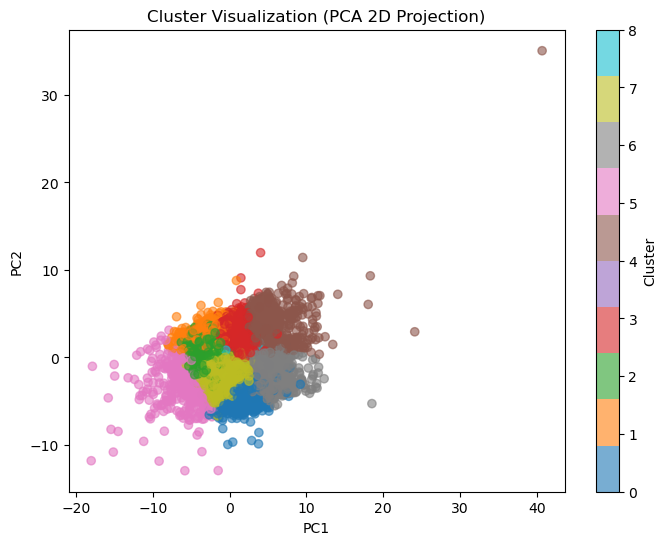


Cluster composition by position (%):
pos         C    PF    PG    SF    SG
cluster                              
0        66.0  28.2   0.7   3.9   1.2
1         2.4  16.7  10.9  33.0  37.1
2         0.4   2.7  56.4  10.6  30.0
3         1.4   9.0  36.6  19.3  33.6
4        10.4  19.6  32.5  17.6  19.9
5        16.3  17.1  19.6  17.8  29.2
6        60.1  32.3   0.6   5.9   1.1
7        30.3  32.1   4.8  21.3  11.5
8        13.3  33.0   4.5  31.1  18.1

Cluster feature averages:
           season       age        mp       per  ts_percent    x3p_ar  \
cluster                                                                 
0       -0.147794 -0.087799 -0.623473  0.087339    0.266567 -1.110191   
1        0.503596  0.246366 -0.252025 -0.439117    0.106265  1.425039   
2       -0.161105 -0.131407 -0.514440 -0.449141   -0.498523  0.193645   
3       -0.139105  0.154207  0.959682  0.509298    0.325465  0.271938   
4       -0.104128  0.162592  1.603037  1.732473    0.650089 -0.082780   
5     

In [16]:
    # Phase 3: 
    results, model, preproc, X, X_df, imputer = run_clustering_pipeline(
        configs,
        seasons=seasons,
        n_clusters=best_k,
        use_pca=True,
        n_pca_components=10,
        impute_strategy="mean",
        random_state=42
    )

    print(f"\nRe-trained clustering with k={best_k}")
    scores = evaluate_clustering_quality(X, results["cluster"])
    print("\nFinal clustering quality:")
    for metric, score in scores.items():
        print(f"{metric}: {score:.3f}")

    inspect_pca_feature_importance(X_raw_imputed, feature_names, n_components=5, top_n=5, random_state=42)

    visualise_clusters(X, results["cluster"], random_state=42)

    cluster_summary = summarise_cluster_composition(results)

    profiles, top_feats = get_cluster_profiles(X_raw_imputed, results["cluster"], feature_names, top_n=5)
    print("\nCluster feature averages:")
    print(profiles)
    print("\nTop differentiating features per cluster:")
    for cid, feats in top_feats.items():
        print(f"Cluster {cid}: {feats}")

## Results
**Archetype Examples**

In [56]:
    players = [
        'LeBron James', 'Josh Giddey', 'Johnny Furphy', 
        'Andre Drummond', 'P.J. Tucker', 'Bronny James',  
        'Mac McClung', 'Rudy Gobert', 'Yuri Collins'
    ]
    years = [2025]
    mask = results['player'].isin(players) & results['season'].isin(years)
    print("\nSelected players (2025):")
    print(results[mask])


Selected players (2025):
             player  player_id  season pos  cluster
100    Yuri Collins  colliyu01    2025  PG        7
133  Andre Drummond  drumman01    2025   C        0
162   Johnny Furphy  furphjo01    2025  SG        8
171     Josh Giddey  giddejo01    2025  PG        3
175     Rudy Gobert  goberru01    2025   C        6
239    Bronny James  jamesbr02    2025  SG        2
240    LeBron James  jamesle01    2025  SF        4
323     Mac McClung  mccluma01    2025  SG        5
504     P.J. Tucker  tuckepj01    2025  SF        1


# NBA Player Clustering Analysis (2000–2025)

## Overview
We clustered NBA players from the 2000–2025 seasons using advanced, shooting, and per‑36 statistics.  
The pipeline applied PCA for dimensionality reduction and KMeans with **9 clusters**, producing interpretable player archetypes that align with recognizable basketball roles.

---

- **Silhouette Score**: ~0.13  
- **Calinski‑Harabasz Index**: ~1587
- **Davies‑Bouldin Index**: ~1.7  

These values suggest **moderate separation**: clusters are distinguishable but with some overlap, which is expected in basketball where player roles often blend.

---

## Cluster Archetypes (based on standardized averages & position mix)

| Cluster | Statistical Profile | Likely Archetype |
|--------|----------------------|------------------|
| **0** | Elite rebounding (TRB%, ORB%), high dunk rate, interior finishing, 94% C/PF | **Interior Finishers / Putback Bigs** |
| **1** | High 3P attempt rate, strong spacing metrics (x3p_ar, corner 3s), SG/SF heavy | **3‑and‑D Wings / Floor Spacers** |
| **2** | High assisted 2P FG, low rebounding, 86% guards (PG/SG), low self‑creation | **Low‑Usage Role Guards** |
| **3** | High minutes, strong advanced metrics (PER, OBPM, AST%), guard-heavy | **Primary Creators / Star Guards** |
| **4** | High scoring efficiency (TS%, PER), elite impact (WS, VORP), balanced mix | **All‑NBA Level Stars** |
| **5** | Very poor TS%, PER, BPM, WS/48, balanced positions | **Replacement‑Level Players** |
| **6** | High rebounding, elite dunk volume, strong defensive metrics (DWS), 92% C/PF | **Rim‑Running Bigs / Defensive Anchors** |
| **7** | Midrange-heavy shot profile, low TS%, older seasons, PF/SF mix | **Inefficient Midrange Forwards** |
| **8** | Mixed scoring zones, moderate usage, balanced stats, PF/SF heavy | **Versatile Forwards / Secondary Scorers** |

---

## Highlighted Players (2025 Season)

### Cluster 0: **Rim Protectors / Putback Bigs**
- **Andre Drummond (C)**  
  *Elite rebounder and interior finisher. High dunk frequency, strong TRB%, low spacing metrics. Classic rim-running big.*

### Cluster 1: **3‑and‑D Wings / Floor Spacers**
- **P.J. Tucker (SF)**  
  *Low-usage wing with high corner 3 share and spacing indicators. Defensive-minded veteran role player.*

### Cluster 2: **Low‑Usage Role Guards**
- **Bronny James (SG)**  
  *Guard with low self-creation and high assisted scoring. Fits the mold of a developing off-ball contributor.*

### Cluster 3: **Primary Creators / Star Guards**
- **Josh Giddey (PG)**  
  *High AST%, OBPM, and minutes played. Versatile playmaker and offensive initiator.*

### Cluster 4: **All‑NBA Level Stars**
- **LeBron James (SF)**  
  *Elite impact across scoring, playmaking, and advanced metrics. Clustered with MVP-level contributors.*

### Cluster 5: **Replacement‑Level Players**
- **Mac McClung (SG)**  
  *Low efficiency across TS%, PER, BPM, and WS/48. Statistically aligned with fringe rotation players.*

### Cluster 6: **Rim‑Running Bigs / Defensive Anchors**
- **Rudy Gobert (C)**  
  *High dunk volume, elite defensive metrics (DWS), and rebounding. Anchors the paint on both ends.*

### Cluster 7: **Inefficient Midrange Forwards**
- **Yuri Collins (PG)**  
  *Low TS%, midrange-heavy shot profile, poor efficiency. May reflect limited offensive impact or small sample size. A near extinct player type that was far more prominent in earlier seasons*


### Cluster 8: **Versatile Forwards / Secondary Scorers**
- **Johnny Furphy (SG)**  
  *Balanced scoring profile with moderate usage. Mix of inside/outside shooting and solid per-36 production.*

## Practical Applications
- **Scouting**: Identify players with similar statistical fingerprints.  
- **Team Building**: Balance rosters by mixing creators, finishers, and role players.  
- **Fan Analysis**: Explore how stars and role players fit into broader categories.


In [64]:
archetype_map = {
    0: "Rim Protectors / Putback Bigs",
    1: "3-and-D Wings / Floor Spacers",
    2: "Low-Usage Role Guards",
    3: "Primary Creators / Star Guards",
    4: "All-NBA Level Stars",
    5: "Replacement-Level Players",
    6: "Rim-Running Bigs / Defensive Anchors",
    7: "Inefficient Midrange Forwards",
    8: "Versatile Forwards / Secondary Scorers"
}

results["cluster"] = results["cluster"].astype(int)

results["archetype"] = results["cluster"].map(archetype_map)

results = results[["player", "season", "pos", "archetype"]]

print(results)

                  player  season pos                               archetype
0       Precious Achiuwa    2025   C           Rim Protectors / Putback Bigs
1           Steven Adams    2025   C           Rim Protectors / Putback Bigs
2            Bam Adebayo    2025   C    Rim-Running Bigs / Defensive Anchors
3           Ochai Agbaji    2025  SG  Versatile Forwards / Secondary Scorers
4           Santi Aldama    2025  PF  Versatile Forwards / Secondary Scorers
...                  ...     ...  ..                                     ...
12612  Dedric Willoughby    2000  PG                   Low-Usage Role Guards
12613      David Wingate    2000  SG               Replacement-Level Players
12614   Haywoode Workman    2000  PG                   Low-Usage Role Guards
12615    Lorenzen Wright    2000   C           Inefficient Midrange Forwards
12616          Tim Young    2000   C           Inefficient Midrange Forwards

[12617 rows x 4 columns]


## Output

In [65]:
results.to_csv("nba_player_archetypes.csv", index=False)